In [3]:
import warnings
import pandas as pd
import requests
import io
import os
import socket
from zipfile import ZipFile

import numpy as np

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score,accuracy_score ,recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score



In [4]:
warnings.filterwarnings("ignore")

2 - Faça o download da base - esta é uma base real, apresentada no artigo:
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

Ela possui uma variável denominada "quality", uma nota de 0 a 10 que denota a qualidade do vinho. Crie uma nova variável, chamada "opinion" que será uma variável categórica igual à 0, quando quality for menor e igual à 5. O valor será 1, caso contrário. Desconsidere a variável quality para o restante da análise.
negrito

In [3]:
def internet(host="8.8.8.8", port=53, timeout=3):
    """
    Host: 8.8.8.8 (google-public-dns-a.google.com)
    OpenPort: 53/tcp
    Service: domain (DNS/TCP)
    """
    try:
        socket.setdefaulttimeout(timeout)
        socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect((host, port))
        return True
    except socket.error as ex:
        print(ex)
        return False

In [4]:
def get_data():
  url = "https://www.kaggle.com/api/v1/datasets/download/rajyellow46/wine-quality"
  response = requests.get(url, stream=True, verify=False)
  with ZipFile(io.BytesIO(response.content)) as myzip:
      with myzip.open(myzip.namelist()[0]) as myfile:
        df = pd.read_csv(myfile)
  return df

In [5]:
#Aquisição do dataset, multi ambiente
if 'google.colab' in str(get_ipython()):
  if internet() == True:
    df = get_data()
  else:
    print('Sem conexão com a internet')
else:
  try:
    df = pd.read_csv('./wine-quality.csv', sep=';')
  except:
    print('Arquivo não encontrado')
    if internet() == True:
      df = get_data()
      df.to_csv('./wine-quality.csv', index=False)
    else:
      print('Sem conexão com a internet')

In [6]:
data = df.copy()

In [7]:
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed_acidity         6487 non-null   float64
 2   volatile_acidity      6489 non-null   float64
 3   citric_acid           6494 non-null   float64
 4   residual_sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free_sulfur_dioxide   6497 non-null   float64
 7   total_sulfur_dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   ph                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [9]:
#Contando linhas nulas para tomar decisão
null_rows_count = df.isnull().any(axis=1).sum()
print('-'*100)
print(f"Linhas nulas: {null_rows_count}")
print('-'*100)
print('\n')
print('-'*100)
print(f"Total de Linhas: {len(df)}")
print('-'*100)
print('\n')
print('-'*100)
print(f'Porcentagem de Linhas nulas: {round((null_rows_count/len(df)),3)} %  -> Menor do que 2% do dataset')
print('-'*100)


----------------------------------------------------------------------------------------------------
Linhas nulas: 34
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Total de Linhas: 6497
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Porcentagem de Linhas nulas: 0.005 %  -> Menor do que 2% do dataset
----------------------------------------------------------------------------------------------------


In [10]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [11]:
df.shape

(6497, 13)

In [12]:
df.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [13]:
#verificando balanceamento entre vinhos brancos e tintos
df.type.value_counts()

,count
type,
white,4898
red,1599


In [14]:
#limpeza nos dados
df = df.drop_duplicates()
df = df.dropna() #optei por eliminar os registros nulos pela baixa incidência na base, não acredito que faria tanta diferença preencher com a mediana esses casos.

In [15]:
# Gerando um pairplot para verificação das condições do dataset
sns.pairplot(df, hue='type')
plt.show()


Output hidden; open in https://colab.research.google.com to view.

<Axes: >

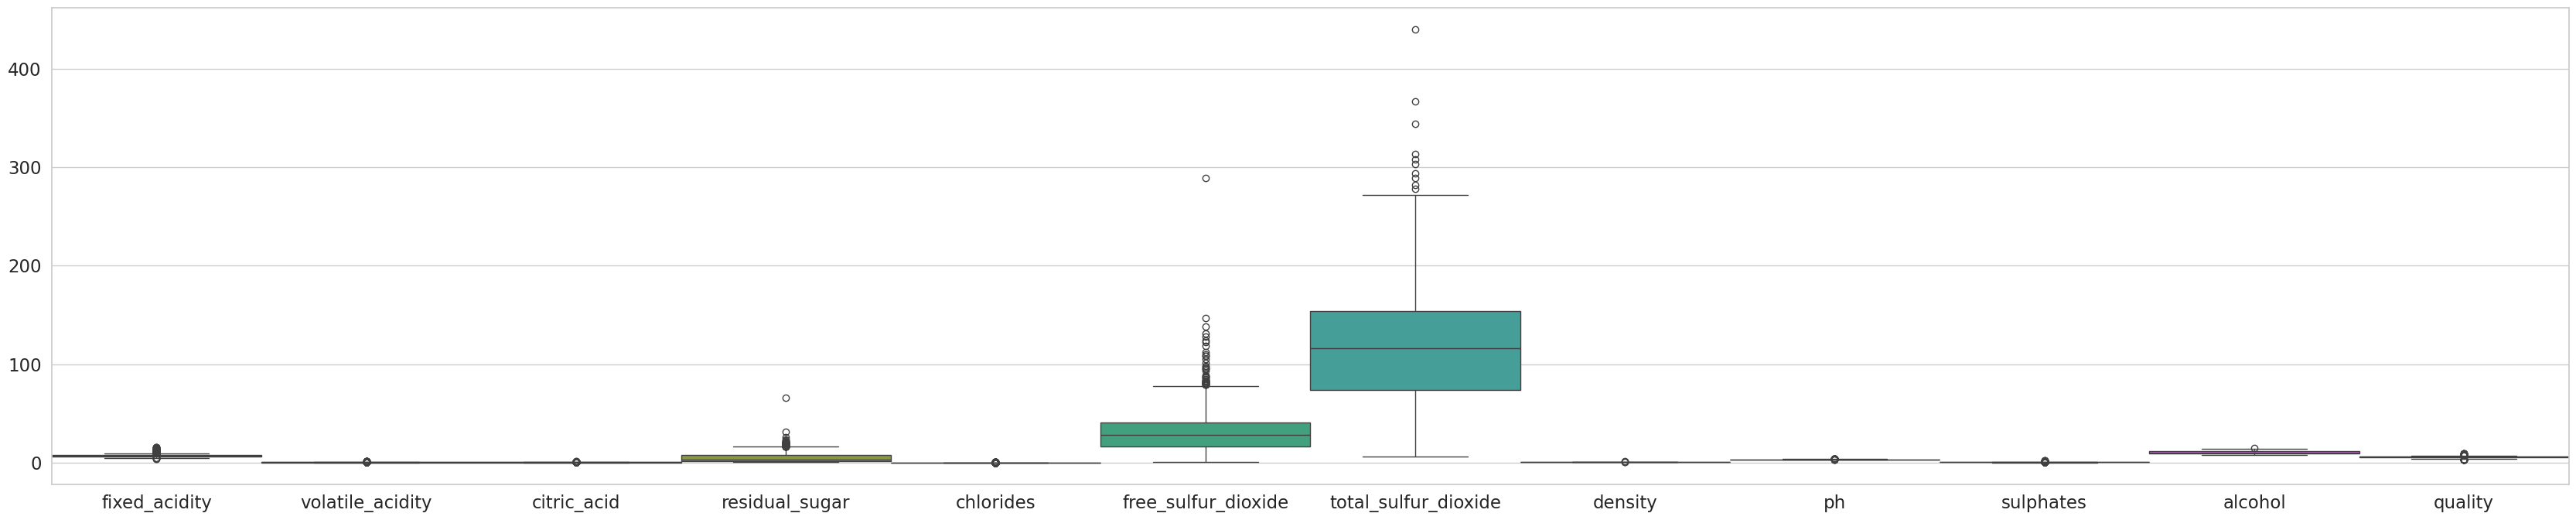

In [16]:
#Boxplot para verificação de outliers

sns.set(rc={'figure.figsize':(42,8)}, font_scale=1.5, style='whitegrid')
sns.boxplot(data=df, width=1)

In [17]:
#analisando total sulfur dioxide mais detalhadamente
df[['total_sulfur_dioxide','free_sulfur_dioxide','residual_sugar']].describe()

,total_sulfur_dioxide,free_sulfur_dioxide,residual_sugar
count,5295.000000,5295.000000,5295.000000
mean,114.118225,30.046837,5.051029
std,56.787187,17.827151,4.500641
min,6.000000,1.000000,0.600000
25%,74.000000,16.000000,1.800000
50%,116.000000,28.000000,2.700000
75%,154.000000,41.000000,7.500000
max,440.000000,289.000000,65.800000


In [18]:
#listando outliers para analise
print('-'*100)
print('\n')
print('Outliers free sulfur dioxide:')
display(df.query('free_sulfur_dioxide > 200').sort_values('free_sulfur_dioxide', ascending=False))
print('\n')

print('-'*100)
print('\n')
print('Outliers total sulfur dioxide:')
display(df.query('total_sulfur_dioxide > 330').sort_values('total_sulfur_dioxide', ascending=False))
print('\n')

print('-'*100)
print('\n')
print('Outliers residual_sugar:')
display(df.query('residual_sugar > 50').sort_values('residual_sugar', ascending=False))
print('\n')

----------------------------------------------------------------------------------------------------


Outliers free sulfur dioxide:


,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
4745,white,6.1,0.26,0.25,2.9,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3




----------------------------------------------------------------------------------------------------


Outliers total sulfur dioxide:


,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
4745,white,6.1,0.26,0.25,2.90,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3
1417,white,8.6,0.55,0.35,15.55,0.057,35.5,366.5,1.00010,3.04,0.63,11.0,3
2127,white,9.1,0.33,0.38,1.70,0.062,50.5,344.0,0.99580,3.10,0.70,9.5,5




----------------------------------------------------------------------------------------------------


Outliers residual_sugar:


,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
2781,white,7.8,0.965,0.6,65.8,0.074,8.0,160.0,1.03898,3.39,0.69,11.7,6


No dataset, cheguei ao entendimento que possivelmente os vinhos com free sulfur dioxide altos, e total sulfur dioxide altos seriam fahas de registro. Contudo, o vinho com residual sugar mais alto, pode ser simplemente um vinho mais doce ou liquoroso, vinho do porto por exemplo.

In [19]:
# Removendo outliers
df = df[df['free_sulfur_dioxide'] <= 200]
df = df[df['total_sulfur_dioxide'] <= 330]

In [20]:
#valores de média e mediana mais aproximados
df[['total_sulfur_dioxide','free_sulfur_dioxide']].describe()

,total_sulfur_dioxide,free_sulfur_dioxide
count,5292.000000,5292.000000
mean,113.965514,29.993008
std,56.431300,17.470724
min,6.000000,1.000000
25%,74.000000,16.000000
50%,116.000000,28.000000
75%,153.000000,41.000000
max,313.000000,146.500000


In [21]:
df.columns

Index(['type', 'fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'density', 'ph', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')

<Axes: >

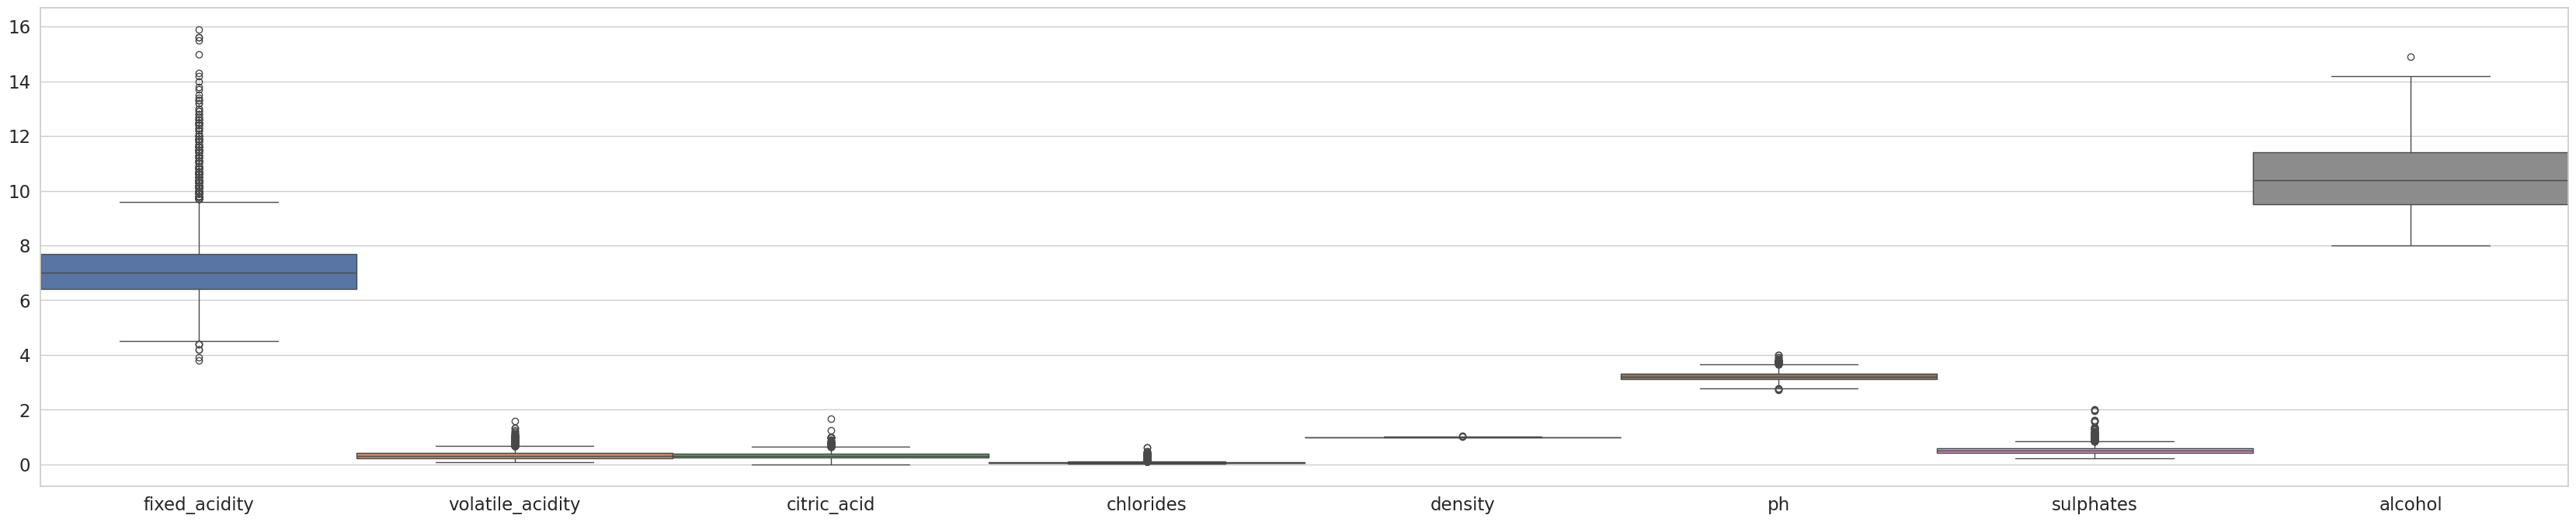

In [22]:
#verificando mais uma vez a presença de outliers, desconsiderando as colunas já tratadas
sns.set(rc={'figure.figsize':(42,8)}, font_scale=1.5, style='whitegrid')
sns.boxplot(data=df[['fixed_acidity', 'volatile_acidity', 'citric_acid', 'chlorides', 'density', 'ph', 'sulphates', 'alcohol']], width=1)

In [23]:
#dataframe após modificações
df.shape

(5292, 13)

In [24]:
#Mudando a variável categórica type para numérica
label_encoder = LabelEncoder()
df['type'] = label_encoder.fit_transform(df['type'])

In [25]:
# Cria a variável 'opinion' com base na variável 'quality'
df['opinion'] = df['quality'].apply(lambda x: 0 if x <= 5 else 1)

# Remove a variável 'quality' do DataFrame
df = df.drop('quality', axis=1)

In [26]:
# Por fim, como vamos trabalhar com vinhos brancos, separando os datasets

df_red = df[df['type'] == 0].drop('type', axis=1)
df_white = df[df['type'] == 1].drop('type', axis=1)

In [27]:
df_white.opinion.describe()

,opinion
count,3939.000000
mean,0.660320
std,0.473661
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


3 - Descreva as variáveis presentes na base. Quais são as variáveis? Quais são os tipos de variáveis (discreta, categórica, contínua)? Quais são as médias e desvios padrões?







Variáveis Categóricas:


* type → Tipo do vinho (0 = tinto, 1 = branco).
Média: 0.7443 | Desvio Padrão: 0.4363
* opinion (Criada) → Classificação do vinho (0 = ruim, 1 = bom).
Média: 0.6266 | Desvio Padrão: 0.4838

Variáveis Contínuas:
* fixed_acidity → Mede a acidez fixa do vinho.
Média: 7.2176 | Desvio Padrão: 1.3206
* volatile_acidity → Mede a acidez volátil do vinho.
Média: 0.3188 | Desvio Padrão: 0.1471
* citric_acid → Mede o ácido cítrico presente no vinho.
Média: 0.3188 | Desvio Padrão: 0.1471
* residual_sugar → Mede a quantidade de açúcar residual.
Média: 5.0501 | Desvio Padrão: 4.4993
* chlorides → Mede a quantidade de cloretos.
Média: 0.0567 | Desvio Padrão: 0.0369
* free_sulfur_dioxide → Mede o dióxido de enxofre livre.
Média: 29.9930 | Desvio Padrão: 17.4707
* total_sulfur_dioxide → Mede o dióxido de enxofre total.
Média: 113.9655 | Desvio Padrão: 56.4313
* density → Mede a densidade do vinho.
Média: 0.9945 | Desvio Padrão: 0.00297
* pH → Mede o pH do vinho.
Média: 3.2244 | Desvio Padrão: 0.1601
* sulphates → Mede a presença de sulfatos no vinho.
Média: 0.5331 | Desvio Padrão: 0.1499
* alcohol → Mede o teor alcoólico do vinho.
Média: 10.5503 | Desvio Padrão: 1.1868

Variável Descartada:

* quality (Dropada) → Medida discreta da qualidade do vinho (de 3 a 9).
Motivo: Foi transformada na variável opinion para classificação binária.

4 - Com a base escolhida:

a. Descreva as etapas necessárias para criar um modelo de classificação eficiente.



R: Para implementar um modelo de classificação eficiente, o primeiro passo é o tratamento dos dados. Isto inclui a limpeza de inconsistências, tratamento de outliers e normalização dos dados para garantir que atendam às premissas matemáticas e estatísticas do modelo. Por exemplo, variáveis categóricas precisam ser convertidas em numéricas dispondo números ao invés de texto em suas classes, valores precisam passar por normalização ou padronização para interpretação de forma correta pelo modelo. Técnicas que ajudam bastante neste cenário são o OneHotEncoding e o Label Encoding. É de comum importância tentar usar um dataset balanceado, para isto, desde a aquisição dos dados pode-se pensar neste tema ou existem técnicas como SMOTE para ajudar a balancear em determinados casos.

Além disso, para atingir a eficiência, é necessário que seja testado de algumas formas antes de selecionar o melhor modelo ou algoritmo a ser aplicado. Uma técnica comum para isso é a validação cruzada K-fold, onde o modelo é treinado diversas vezes com frações diferentes dos dados, permitindo testar diferentes hiperparâmetros em cada iteração.

Por isto, é importante monitorar métricas de desempenho como Precisão, Recall e F1-Score. Que atuam de forma mais assertiva, sobretudo quando há desbalanceamento de classes. A acurácia pode não evidenciar muitas informações sobre o desempenho do modelo, o que põe em cheque a elaboração de um modelo eficiente. Fica ainda mais interessante quando podemos usar métricas de negócio para mensurar a eficiência do modelo, como BreakEven ou sinalizadores de custo ou lucro de acordo com o desempenho técnico do modelo.


In [28]:
#Verificado o df_white para o atributo opinion e sua separabilidade linear
sns.pairplot(df_white, hue='opinion')

Output hidden; open in https://colab.research.google.com to view.

In [29]:
df_white.head(1)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,opinion
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,1


In [30]:
num = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'ph', 'sulphates', 'alcohol']

In [31]:
#Separando conjuntos X e Y
X = df_white.drop('opinion', axis=1)
y = df_white['opinion']

In [32]:

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)


In [33]:
# separação treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y,random_state=42)

In [40]:
# criando um pipeline de processamento
preprocessor = ColumnTransformer([
       ('numeric', RobustScaler(), num)
])

# criando os pipelines
dt_categ = Pipeline([
    ('transformer', preprocessor),
    ('model', DecisionTreeClassifier(random_state=2))
])


reglog_categ = Pipeline([
    ('transformer', preprocessor),
    ('model', LogisticRegression(solver='saga'))
])


svm_categ = Pipeline([
    ('transformer', preprocessor),
    ('model', SVC(random_state=2))
])

# configurar o espaço de busca
params_grid_dt = {
    'model__max_depth': range(2, 11),
    'model__criterion': ['gini', 'entropy'],
    'model__class_weight': ['balanced', None]
}

params_grid_reglog = {
    'model__penalty': ['l1', 'l2', 'elasticnet', None],
    'model__C': [0.001, 0.01, 0.1, 1, 10],
    'model__l1_ratio': [0.25, 0.5, 0.75],
    'model__class_weight': ['balanced', None]
}

params_svc = {
    'model__kernel': ['rbf', 'sigmoid', 'cosine', 'linear'],
    'model__C': np.random.uniform(0.01, 10, 100),
    'model__gamma': np.random.uniform(0.01, 10, 100),
}

# configurar o amostrador - estratificado
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# configurar o buscador
search_dt_categ = GridSearchCV(
    estimator=dt_categ,
    param_grid=params_grid_dt,
    scoring='f1',
    cv=splitter,
    refit=True,
    error_score=0,
    verbose=10
)

search_reg_log_categ = GridSearchCV(
    estimator=reglog_categ,
    param_grid=params_grid_reglog,
    scoring='f1',
    cv=splitter,
    refit=True,
    error_score=0,
    verbose=10
)

random_search_svc = RandomizedSearchCV(
    estimator=svm_categ,
    param_distributions=params_svc,
    n_iter=50,
    scoring='f1_weighted',
    cv=splitter,
    refit=True,
    error_score=0
)

In [41]:
search_reg_log_categ.fit(X_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
[CV 1/10; 1/120] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1
[CV 1/10; 1/120] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1;, score=0.668 total time=   0.0s
[CV 2/10; 1/120] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1
[CV 2/10; 1/120] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1;, score=0.667 total time=   0.0s
[CV 3/10; 1/120] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1
[CV 3/10; 1/120] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1;, score=0.667 total time=   0.0s
[CV 4/10; 1/120] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1
[CV 4/10; 1/120] END model__C=0.001, model__class_weight=balanced, model__l1_ra

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         RobustScaler(),
                                                                         ['fixed_acidity',
                                                                          'volatile_acidity',
                                                                          'citric_acid',
                                                                          'residual_sugar',
                                                                          'chlorides',
                                                                          'free_sulfur_dioxide',
                                                                          'total_sulfur_dioxide',
                                                                          'density',
                                                                          'ph',
                                                                          'sulphates',
                                                                          'alcohol'])])),
                                       ('model',
                                        LogisticRegression(solver='saga'))]),
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10],
                         'model__class_weight': ['balanced', None],
                         'model__l1_ratio': [0.25, 0.5, 0.75],
                         'model__penalty': ['l1', 'l2', 'elasticnet', None]},
             scoring='f1', verbose=10)

In [42]:
search_dt_categ.fit(X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 1/10; 1/36] START model__class_weight=balanced, model__criterion=gini, model__max_depth=2
[CV 1/10; 1/36] END model__class_weight=balanced, model__criterion=gini, model__max_depth=2;, score=0.746 total time=   0.0s
[CV 2/10; 1/36] START model__class_weight=balanced, model__criterion=gini, model__max_depth=2
[CV 2/10; 1/36] END model__class_weight=balanced, model__criterion=gini, model__max_depth=2;, score=0.764 total time=   0.0s
[CV 3/10; 1/36] START model__class_weight=balanced, model__criterion=gini, model__max_depth=2
[CV 3/10; 1/36] END model__class_weight=balanced, model__criterion=gini, model__max_depth=2;, score=0.754 total time=   0.0s
[CV 4/10; 1/36] START model__class_weight=balanced, model__criterion=gini, model__max_depth=2
[CV 4/10; 1/36] END model__class_weight=balanced, model__criterion=gini, model__max_depth=2;, score=0.743 total time=   0.0s
[CV 5/10; 1/36] START model__class_weight=balanced, model__cr

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         RobustScaler(),
                                                                         ['fixed_acidity',
                                                                          'volatile_acidity',
                                                                          'citric_acid',
                                                                          'residual_sugar',
                                                                          'chlorides',
                                                                          'free_sulfur_dioxide',
                                                                          'total_sulfur_dioxide',
                                                                          'density',
                                                                          'ph',
                                                                          'sulphates',
                                                                          'alcohol'])])),
                                       ('model',
                                        DecisionTreeClassifier(random_state=2))]),
             param_grid={'model__class_weight': ['balanced', None],
                         'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': range(2, 11)},
             scoring='f1', verbose=10)

In [43]:
random_search_svc.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   error_score=0,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               RobustScaler(),
                                                                               ['fixed_acidity',
                                                                                'volatile_acidity',
                                                                                'citric_acid',
                                                                                'residual_sugar',
                                                                                'chlorides',
                                                                                'free_sulfur_dioxide',
                                                                                'total_sulfur_dioxide',
                                                                                'density',
                                                                                'ph',
                                                                                'sulphates',
                                                                                'alcoh...
       8.14108719, 7.49305507, 0.49412732, 3.77818003, 8.04644205,
       3.51919297, 7.76748642, 3.52861631, 9.49596987, 8.77032513,
       6.71385277, 0.15854554, 2.4834552 , 1.2159294 , 5.91326793,
       2.59154004, 4.11208459, 8.96032873, 0.18896846, 7.91450154,
       7.93749888, 2.49760439, 2.09194294, 8.78462295, 0.86175337]),
                                        'model__kernel': ['rbf', 'sigmoid',
                                                          'cosine', 'linear']},
                   scoring='f1_weighted')

In [44]:
def get_metrics(grid_search):
  ''' Função para aquisição de métricas dos modelos testados em validação cruzada'''
  # Criar listas para armazenar os valores das métricas em cada fold
  accuracy_list = []
  precision_list = []
  recall_list = []
  f1_list = []

  for train_index, test_index in splitter.split(X_train, y_train):
      X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
      y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

      model = grid_search.best_estimator_
      model.fit(X_train_fold, y_train_fold)

      y_pred_fold = model.predict(X_test_fold)

      accuracy_list.append(accuracy_score(y_test_fold, y_pred_fold))
      precision_list.append(precision_score(y_test_fold, y_pred_fold))
      recall_list.append(recall_score(y_test_fold, y_pred_fold))
      f1_list.append(f1_score(y_test_fold, y_pred_fold))

  # Calcular média e desvio padrão das métricas
  metrics_results = {
      "Média Acurácia": np.mean(accuracy_list),
      "Desvio Padrão Acurácia": np.std(accuracy_list),
      "Média Precisão": np.mean(precision_list),
      "Desvio Padrão Precisão": np.std(precision_list),
      "Média Recall": np.mean(recall_list),
      "Desvio Padrão Recall": np.std(recall_list),
      "Média F1-Score": np.mean(f1_list),
      "Desvio Padrão F1-Score": np.std(f1_list),
  }

  df_metrics = pd.DataFrame(metrics_results, index=[0])
  return df_metrics

Logistic Regression

In [45]:
#Visualizando o melhor conjunto de hiperparametros
search_reg_log_categ.best_params_

{'model__C': 0.1,
 'model__class_weight': 'balanced',
 'model__l1_ratio': 0.25,
 'model__penalty': 'elasticnet'}

In [46]:
#melhor score de modelo
search_reg_log_categ.best_score_

0.7443735805845076

In [47]:
# Realizar novas previsões com o melhor desempenho registrado no SearchGrid
yhat_reg_log_categ_train = search_reg_log_categ.best_estimator_.predict(X_train)
yhat_reg_log_categ_test = search_reg_log_categ.best_estimator_.predict(X_test)

print('Desempenho - Base de Treino')
print(classification_report(y_train, yhat_reg_log_categ_train))



print('Desempenho - Base de Teste')
print(classification_report(y_test, yhat_reg_log_categ_test))


Desempenho - Base de Treino
              precision    recall  f1-score   support

           0       0.74      0.77      0.75      1820
           1       0.76      0.73      0.75      1821

    accuracy                           0.75      3641
   macro avg       0.75      0.75      0.75      3641
weighted avg       0.75      0.75      0.75      3641

Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.74      0.77      0.76       781
           1       0.76      0.73      0.75       780

    accuracy                           0.75      1561
   macro avg       0.75      0.75      0.75      1561
weighted avg       0.75      0.75      0.75      1561

Accuracy score:  0.7500686624553694


In [48]:
df_reglog_metrics = get_metrics(search_reg_log_categ)

In [49]:
display(df_reglog_metrics)

,Média Acurácia,Desvio Padrão Acurácia,Média Precisão,Desvio Padrão Precisão,Média Recall,Desvio Padrão Recall,Média F1-Score,Desvio Padrão F1-Score
0,0.749801,0.033196,0.761159,0.03528,0.729274,0.043027,0.744374,0.034789


DecisionTree

In [50]:
#Visualizando o melhor conjunto de hiperparametros
search_dt_categ.best_params_

{'model__class_weight': 'balanced',
 'model__criterion': 'entropy',
 'model__max_depth': 6}

In [51]:
#melhor score de modelo
search_dt_categ.best_score_

0.741981776040629

In [55]:
# Realizar novas previsões com o melhor desempenho registrado no SearchGrid
yhat_dt_categ_train = search_dt_categ.best_estimator_.predict(X_train)
yhat_dt_categ_test = search_dt_categ.best_estimator_.predict(X_test)

print('Desempenho - Base de Treino')
print(classification_report(y_train, yhat_dt_categ_train))



print('Desempenho - Base de Teste')
print(classification_report(y_test, yhat_dt_categ_test))

Desempenho - Base de Treino
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1820
           1       0.79      0.77      0.78      1821

    accuracy                           0.79      3641
   macro avg       0.79      0.79      0.79      3641
weighted avg       0.79      0.79      0.79      3641

Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       781
           1       0.76      0.74      0.75       780

    accuracy                           0.76      1561
   macro avg       0.76      0.76      0.76      1561
weighted avg       0.76      0.76      0.76      1561



In [53]:
df_dt_metrics = get_metrics(search_dt_categ)

In [54]:
display(df_dt_metrics)

,Média Acurácia,Desvio Padrão Acurácia,Média Precisão,Desvio Padrão Precisão,Média Recall,Desvio Padrão Recall,Média F1-Score,Desvio Padrão F1-Score
0,0.744025,0.023796,0.748676,0.02844,0.73639,0.033548,0.741982,0.024323


Support Vector Machines

In [56]:
#Visualizando o melhor conjunto de hiperparametros
random_search_svc.best_params_

{'model__kernel': 'rbf',
 'model__gamma': 1.2159294011449389,
 'model__C': 5.530170067518507}

In [57]:
#melhor score de modelo
random_search_svc.best_score_

0.8002693783860071

In [60]:
# Realizar novas previsões com o melhor desempenho registrado no SearchGrid
yhat_svm_categ_train = random_search_svc.best_estimator_.predict(X_train)
yhat_svm_categ_test = random_search_svc.best_estimator_.predict(X_test)

print('Desempenho - Base de Treino')
print(classification_report(y_train, yhat_svm_categ_train))



print('Desempenho - Base de Teste')
print(classification_report(y_test, yhat_svm_categ_test))

Desempenho - Base de Treino
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1820
           1       1.00      0.99      1.00      1821

    accuracy                           1.00      3641
   macro avg       1.00      1.00      1.00      3641
weighted avg       1.00      1.00      1.00      3641

Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       781
           1       0.80      0.81      0.80       780

    accuracy                           0.80      1561
   macro avg       0.80      0.80      0.80      1561
weighted avg       0.80      0.80      0.80      1561



In [61]:
df_svm_metrics = get_metrics(random_search_svc)

In [62]:
display(df_svm_metrics)

,Média Acurácia,Desvio Padrão Acurácia,Média Precisão,Desvio Padrão Precisão,Média Recall,Desvio Padrão Recall,Média F1-Score,Desvio Padrão F1-Score
0,0.800331,0.017051,0.794477,0.021423,0.8111,0.017322,0.802555,0.016169


5  - Em relação à questão anterior, qual o modelo deveria ser escolhido para uma eventual operação. Responda essa questão mostrando a comparação de todos os modelos, usando um gráfico mostrando a curva ROC média para cada um dos gráficos e justifique.

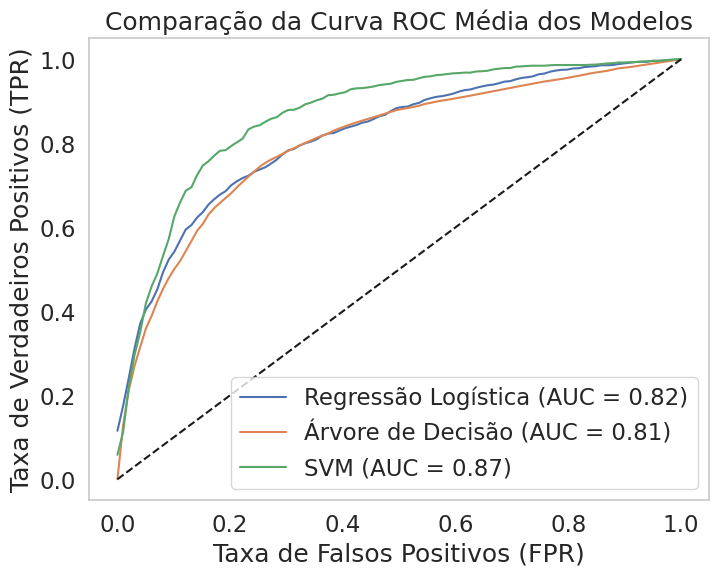

In [66]:
roc_data = {}

# Rodando validação cruzada e coletando probabilidades para cada modelo
for model_name, grid_search in zip(["Regressão Logística", "Árvore de Decisão", "SVM"],
                                   [search_reg_log_categ, search_dt_categ, random_search_svc]):

    # Definir validação cruzada
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    mean_fpr = np.linspace(0, 1, 100)  # Eixos para interpolação
    tprs = []
    aucs = []

    # Loop pelos folds
    for train_index, test_index in kfold.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Treinar o modelo no fold atual
        model = grid_search.best_estimator_
        model.fit(X_train_fold, y_train_fold)

        # Prever probabilidades
        if hasattr(model, "predict_proba"):
          y_proba = model.predict_proba(X_test_fold)[:, 1]
        else:
          # Se `predict_proba` não estiver disponível, use `decision_function` (exemplo para SVM)
          y_proba = model.decision_function(X_test_fold)


        # Calcular ROC
        fpr, tpr, _ = roc_curve(y_test_fold, y_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))  # Interpolação para suavizar a curva
        aucs.append(roc_auc_score(y_test_fold, y_proba))

    # Salvar os dados médios para o modelo
    roc_data[model_name] = {
        "mean_fpr": mean_fpr,
        "mean_tpr": np.mean(tprs, axis=0),
        "mean_auc": np.mean(aucs)
    }

# Plotando a curva ROC média para cada modelo
plt.figure(figsize=(8, 6))
for model_name, data in roc_data.items():
    plt.plot(data["mean_fpr"], data["mean_tpr"], label=f'{model_name} (AUC = {data["mean_auc"]:.2f})')

# Configuração do gráfico
plt.plot([0, 1], [0, 1], 'k--')  # Linha de referência
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Comparação da Curva ROC Média dos Modelos")
plt.legend()
plt.grid()

# Exibir o gráfico
plt.show()

Com base no apresentado pela curva ROC, podemos ver que além das métricas de F1 Score, Precisão, Recall e Acurácia previamente verificadas, a curva de verdadeiros positivos é bem mais destacada no modelo SVM. Por tanto, do ponto de vista de desempenho do modelo, o SVM supera os demais neste quesito. Contudo, é muito impotante destacar que a quantidade de processamento utilizada por este modelo foi superior, e embora não quantificada em termos memória, apenas a título de comparação o tempo de processamento dos modelos foram:

* Regressão Logistica - 2 minutos
* Árvore de Decisão - 15 segundos
* Maquinas de Vetores de Suporte - 6 minutos

Entre todas as métricas solicitadas pela atividade até aqui, eu escolheria o SVM como modelo ótimo para nossa classificação.

6 - Com a escolha do melhor modelo, use os dados de vinho tinto, presentes na base original e faça a inferência (não é para treinar novamente!!!) para saber quantos vinhos são bons ou ruins. Utilize o mesmo critério utilizado com os vinhos brancos, para comparar o desempenho do modelo. Ele funciona da mesma forma para essa nova base? Justifique.


In [75]:
# Separar X (features) e y (target/opinion)
X_tinto = df_red[num]  # 'num' contém as colunas numéricas usadas no treino (criado la trás na outra implementação)
y_tinto = df_red["opinion"]  # Target


X_tinto_transformed = random_search_svc.best_estimator_.named_steps["transformer"].transform(X_tinto)

X_tinto_transformed = pd.DataFrame(X_tinto_transformed, columns=num, index=X_tinto.index)

# Fazer previsões com o modelo já treinado (sem re-treinar)
y_pred_tinto = random_search_svc.best_estimator_.predict(X_tinto_transformed)

# Contar quantos vinhos tintos foram classificados como bons e ruins
num_bons = np.sum(y_pred_tinto == 1)
num_ruins = np.sum(y_pred_tinto == 0)

print(f"Total de vinhos tintos classificados como bons: {num_bons}")
print(f"Total de vinhos tintos classificados como ruins: {num_ruins}")


Total de vinhos tintos classificados como bons: 1353
Total de vinhos tintos classificados como ruins: 0


In [80]:
#verificando balanceamento de classes em busca de explicações para o resultado
y_tinto.value_counts()

,count
opinion,
1,715
0,638


In [77]:
print(classification_report(y_tinto, y_pred_tinto))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       638
           1       0.53      1.00      0.69       715

    accuracy                           0.53      1353
   macro avg       0.26      0.50      0.35      1353
weighted avg       0.28      0.53      0.37      1353



O modelo SVM treinado com dados de vinhos brancos se mostrou ineficiente na classificação de vinhos tintos, principalmente devido à diferença estatística entre os dois tipos de vinho e ao perfil do SVM com kernel RBF.

Durante o treinamento, o modelo estabeleceu um hiperplano de separação adequado apenas para os vinhos brancos, criando uma fronteira de decisão que não se generaliza bem para os vinhos tintos. Isso ocorre porque o kernel rbf mapeia os dados para um espaço dimensional maior, onde o modelo pode ter aprendido padrões específicos demais para os vinhos brancos, prejudicando a generalização.

Essa diferença de desempenho sugere um possível overfitting, pois o modelo não consegue extrapolar seu aprendizado para uma nova distribuição de dados. No entanto, se o objetivo do modelo fosse exclusivamente classificar vinhos brancos, esse comportamento poderia ser aceitável. Em um contexto real, seria necessário reavaliar a estratégia, seja incluindo vinhos tintos no treinamento ou ajustando os hiperparâmetros para melhorar a generalização.

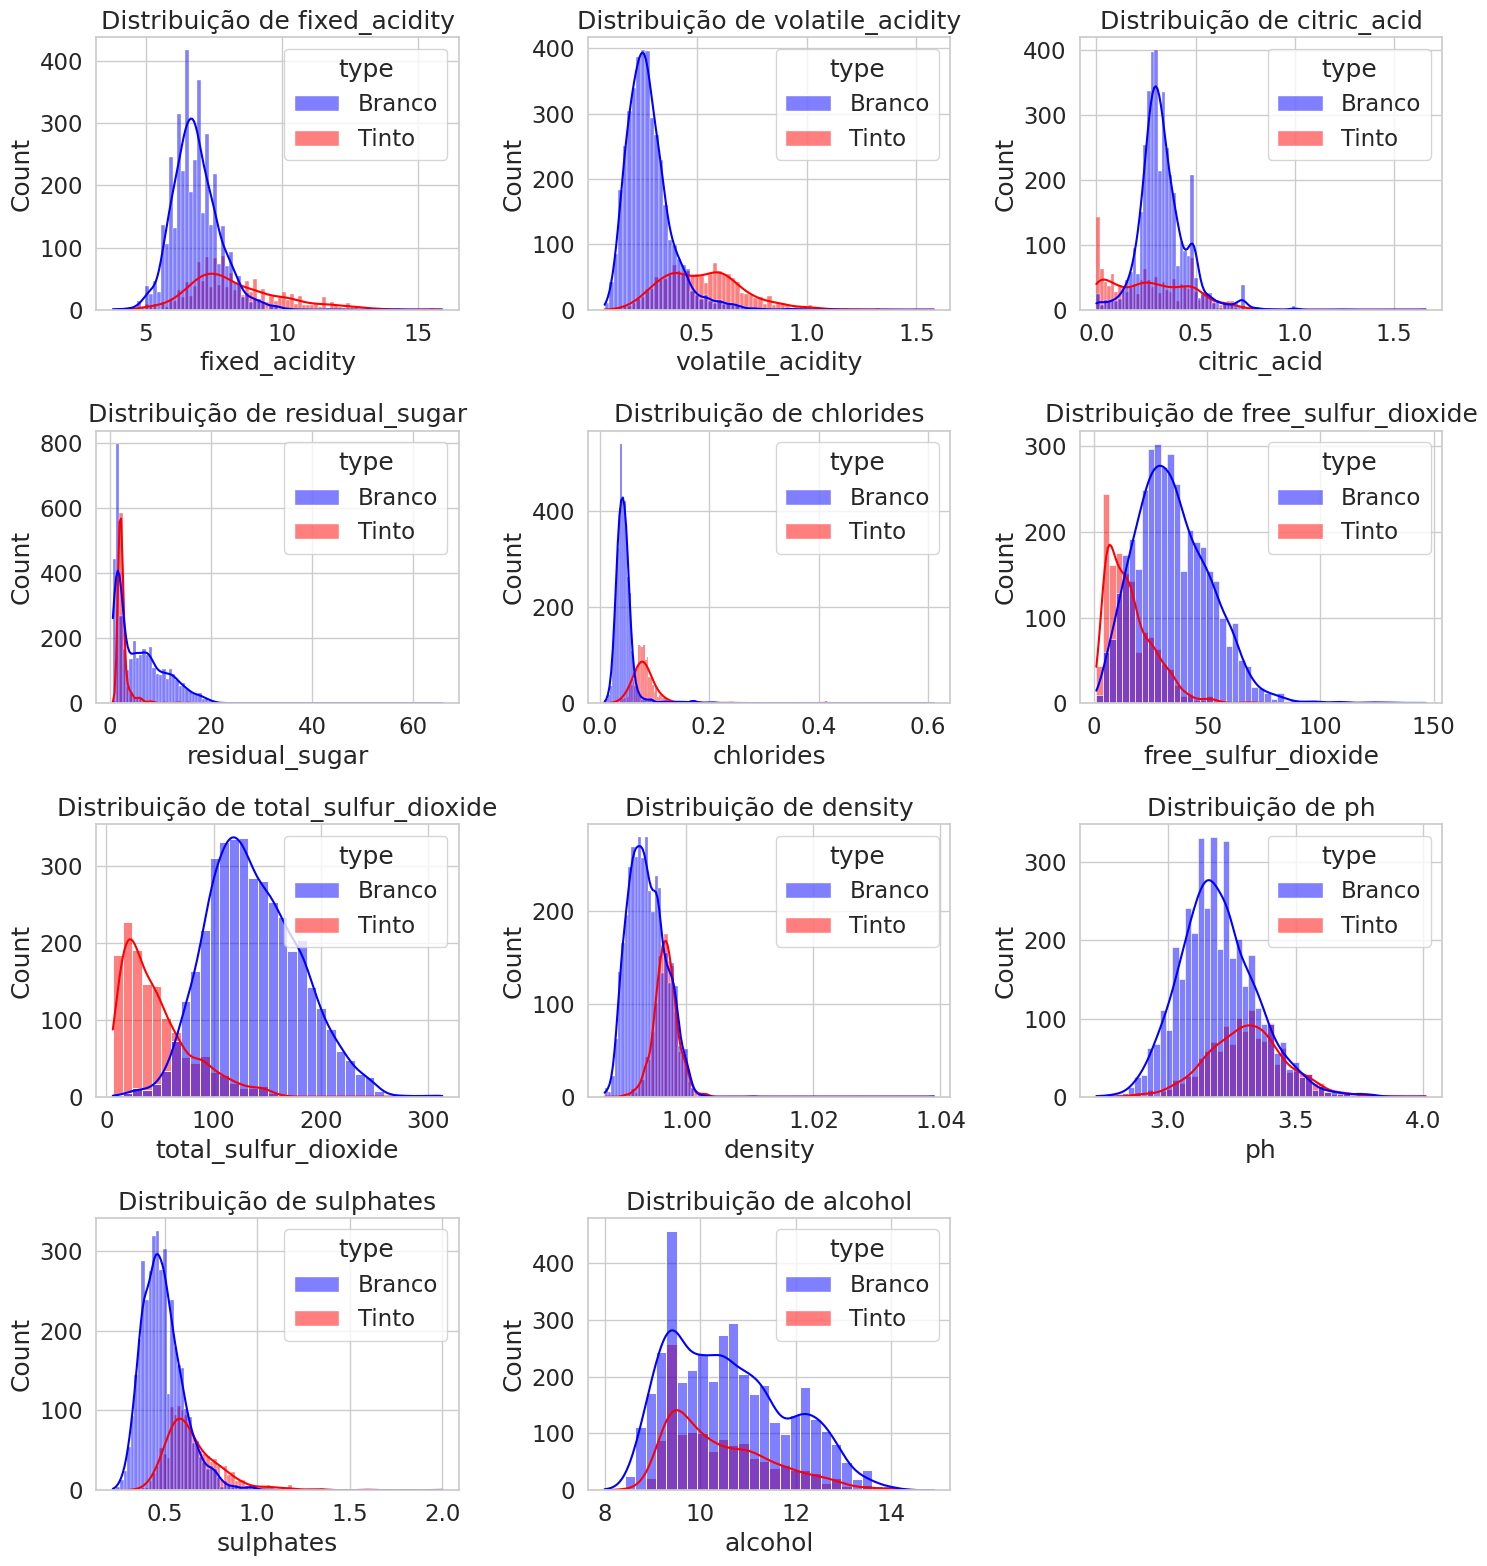

In [87]:
#Explorando os dados na origem para tentarmos entender o resultado
df_vinhos = df.copy()
df_vinhos["type"] = df_vinhos["type"].map({0: "Tinto", 1: "Branco"})  # Converte os tipos para nomes legíveis

num_features = len(num)  # Número de variáveis numéricas
cols = 3  # Quantidade de colunas no layout
rows = (num_features // cols) + (num_features % cols > 0)  # Calcula o número de linhas necessárias

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.flatten()  # Para facilitar a iteração

# Gerar histogramas para cada feature
for i, col in enumerate(num):
    sns.histplot(data=df_vinhos, x=col, hue="type", kde=True, ax=axes[i], palette={"Branco": "blue", "Tinto": "red"})
    axes[i].set_title(f"Distribuição de {col}")

# Remover gráficos vazios caso o número de colunas não seja múltiplo de `cols`
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Claramente observamos a divergência de padrões para tipos de vinhos, é normal pensar que o modelo "Overfittou".

Gerando curva ROC/AUC do modelo dos tintos

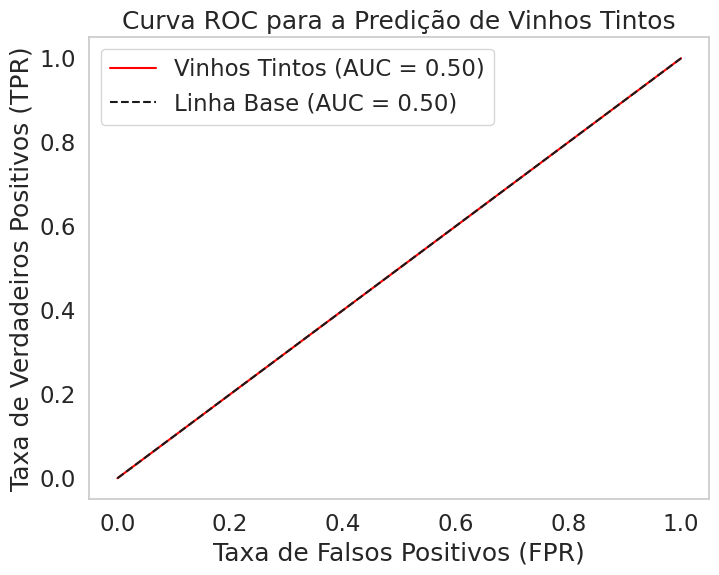

In [90]:
#traçando uma curva roc para o prdict dos tintos
if hasattr(random_search_svc, "predict_proba"):
    y_proba_tinto = random_search_svc.predict_proba(X_tinto_transformed)[:, 1]
else:
    y_proba_tinto = random_search_svc.decision_function(X_tinto_transformed)

# Calcular a curva ROC para os vinhos tintos
fpr, tpr, _ = roc_curve(y_tinto, y_proba_tinto)
auc_score = roc_auc_score(y_tinto, y_proba_tinto)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Vinhos Tintos (AUC = {auc_score:.2f})", color="red")
plt.plot([0, 1], [0, 1], 'k--', label="Linha Base (AUC = 0.50)")

# Configurações do gráfico
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC para a Predição de Vinhos Tintos")
plt.legend()
plt.grid()

# Exibir o gráfico
plt.show()

Como repassado nas aulas, o curva ROC é tão estável, que é basicamente como se estivessemos "chutando" ao invés de classificar.

7 - Disponibilize os códigos usados para responder da questão 2-6 em uma conta github e indique o link para o repositório.
